<a href="https://colab.research.google.com/github/Mnikito/4106/blob/main/ASL_Recognition/ASL_MobileNetV2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle

In [ ]:
# download dataset and extract it
! export KAGGLE_USERNAME="michealnikitin" && export KAGGLE_KEY="12287a73a5ea9f40a4901060014566ab" && kaggle datasets download --unzip amarinderplasma/alphabets-sign-language
! ls

alphabets-sign-language.zip: Skipping, found more recently modified local copy (use --force to force download)
alphabets-sign-language.zip  asl_alphabet_test	 sample_data
asl_alphabet_1		     asl_alphabet_train


In [ ]:
! pwd && ls
print("\nFolders(classess) in training folder: ...")
! cd asl_alphabet_1/asl_alphabet_train && ls

/content
alphabets-sign-language.zip  asl_alphabet_test	 sample_data
asl_alphabet_1		     asl_alphabet_train

Folders(classess) in training folder: ...
A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


In [ ]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

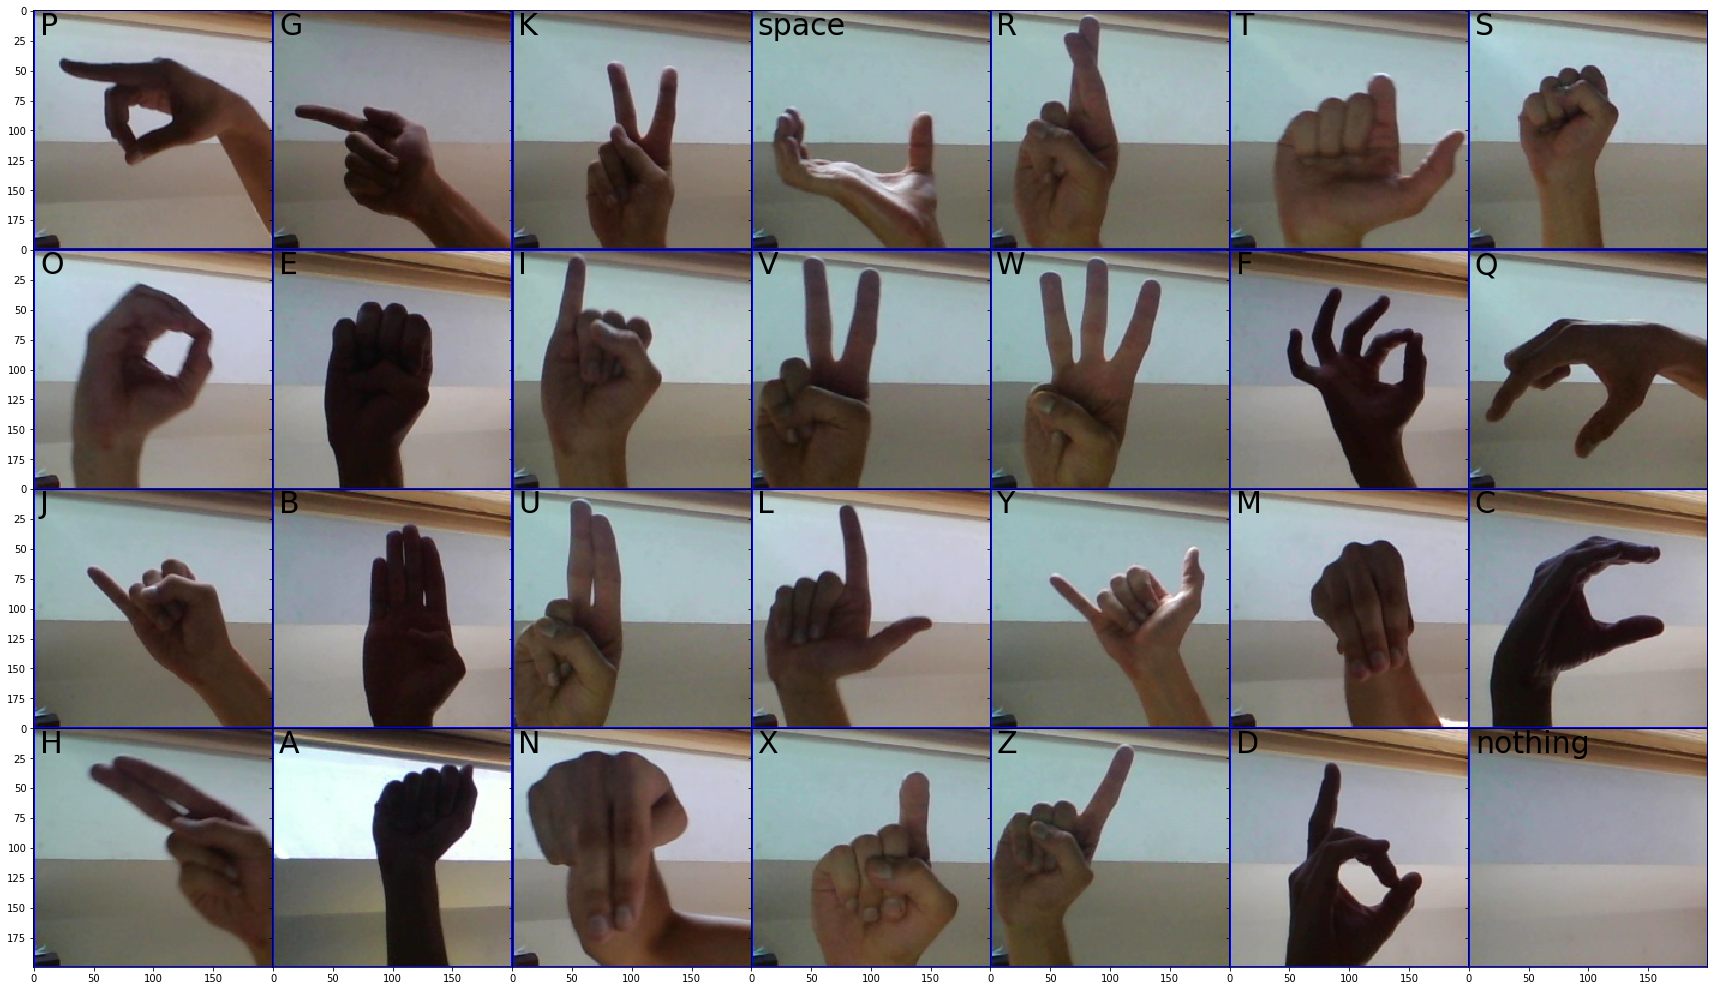

In [ ]:
%matplotlib inline

ASL=np.array(glob.glob('asl_alphabet_test/*')) 

fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 7),  
                 axes_pad=0,  # pad between axes in inch.
                 )
l=0
for img in ASL:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(5,20, img.split('/')[1].split('_')[0] ,fontsize=30)
        l+=1

In [ ]:
#creating the dataloaders 

# Define transforms for the training data and testing data
train_path='asl_alphabet_1/asl_alphabet_train'
valid_path='asl_alphabet_1/asl_alphabet_valid'

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [ ]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print used Device
print(f"Device used: {torch.cuda.get_device_name(0)}")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")

Device used: Tesla K80
class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [ ]:
# choose a pretrained model to start with check options here: https://pytorch.org/docs/stable/torchvision/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network 
for param in model.parameters():
    param.requires_grad = False
    
#print the model to check the classifer and change it
print (model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True  

    
# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)

Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
  (2): LogSoftmax(dim=1)
)


In [ ]:
#Define number of epochs through data and run the training loop
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 2
step = 0
running_loss = 0
print_every = 5
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [ ]:
%%time

for epoch in range(epochs):
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in trainloader:
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
                    
                        

            print(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0
            
        
    scheduler.step()
    step=0

--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 2) ... Step  (  5 of 142) ... Train loss: 3.171 ... Test loss: 2.688 ... Test accuracy: 0.450 
Epoch (1 of 2) ... Step  ( 10 of 142) ... Train loss: 2.385 ... Test loss: 1.711 ... Test accuracy: 0.615 
Epoch (1 of 2) ... Step  ( 15 of 142) ... Train loss: 1.659 ... Test loss: 1.133 ... Test accuracy: 0.759 
Epoch (1 of 2) ... Step  ( 20 of 142) ... Train loss: 1.220 ... Test loss: 0.836 ... Test accuracy: 0.811 
Epoch (1 of 2) ... Step  ( 25 of 142) ... Train loss: 0.922 ... Test loss: 0.679 ... Test accuracy: 0.849 
Epoch (1 of 2) ... Step  ( 30 of 142) ... Train loss: 0.716 ... Test loss: 0.556 ... Test accuracy: 0.894 
Epoch (1 of 2) ... Step  ( 35 of 142) ... Train loss: 0.568 ... Test loss: 0.456 ... Test accuracy: 0.920 
Epoch (1 of 2) ... Step  ( 40 of 142) ... Train loss: 0.454 ... Test loss: 0.387 ... Test accuracy: 0.923 
Epoch (1 of 2) ... Step  ( 45 of 142)

In [ ]:
torch.save(model.state_dict(), 'MobileNetV2_ASL.pt')